# Palmer Penguins

In this notebook, a classification of penguins into 3 species is carried out based on [Palmer Penguins dataset](https://allisonhorst.github.io/palmerpenguins/) {cite:p}`palmerpenguins`. The dataset in CSV format used is downloaded from [here](https://gist.github.com/slopp/ce3b90b9168f2f921784de84fa445651). Additionally, a simple mislabeling experiment is carried out to learn the outcomes of uncertainty in data annotation quality.

After some data explpration, a simple SVM model is trained to classify species of penguins based on 2 features selected from a data analysis.Finally, we look into a simple experiment of how decreasing in annotation quality, in which some labels are misclassified, would affect the outcome of an ML model.

This tutorial contains machine learning routines from [ml.recipes](https://ml.recipes) book by [Jesper Dramsch](https://ml.recipes).

## Prerequisites
- Python programming basics such as imports, variables, loops, and list indexing and slicing.
- Basics of multi-dimensional array and tabular libraries like `numpy` and `pandas`
- Data plotting with `matplotlib`

If you run the notebook locally, it is recommended to do it with a virtual environment or environment management like `conda`.

The libraries required are:
- `numpy`
- `pandas`
- `matplotlib`
- `seaborn`
- `scikit-learn`
- `ipywidgets`

## Read the data file

Let's have the data loaded and briefly look at the data.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

DATA_FOLDER = Path("..") / "data"
DATA_FILEPATH = DATA_FOLDER / "penguins.csv"
# If the above path doesn't work on cloud platform (e.g. colab), try this path instead
# DATA_FILEPATH = "https://raw.githubusercontent.com/jeepchinnawat/edumat-book/main/data/penguins.csv"

penguins = pd.read_csv(DATA_FILEPATH)
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              344 non-null    int64  
 1   species            344 non-null    object 
 2   island             344 non-null    object 
 3   bill_length_mm     342 non-null    float64
 4   bill_depth_mm      342 non-null    float64
 5   flipper_length_mm  342 non-null    float64
 6   body_mass_g        342 non-null    float64
 7   sex                333 non-null    object 
 8   year               344 non-null    int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 24.3+ KB


In [2]:
penguins.head()

rowid species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0      1  Adelie  Torgersen            39.1           18.7              181.0   
1      2  Adelie  Torgersen            39.5           17.4              186.0   
2      3  Adelie  Torgersen            40.3           18.0              195.0   
3      4  Adelie  Torgersen             NaN            NaN                NaN   
4      5  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
3          NaN     NaN  2007  
4       3450.0  female  2007

It looks like there is some missing values like in the row number 4 (and maybe more), which a little data cleaning can take care of.

In [3]:
penguins = penguins.dropna(axis='rows')
penguins.head()

rowid species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0      1  Adelie  Torgersen            39.1           18.7              181.0   
1      2  Adelie  Torgersen            39.5           17.4              186.0   
2      3  Adelie  Torgersen            40.3           18.0              195.0   
4      5  Adelie  Torgersen            36.7           19.3              193.0   
5      6  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
4       3450.0  female  2007  
5       3650.0    male  2007

Making references to different selected groups of features and the target variable (to be classified) will help and be reused down the line.

In [4]:
num_features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
cat_features = ["sex"]
features = num_features + cat_features
target = ["species"]
penguins = penguins[features+target]
penguins

bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g     sex  \
0              39.1           18.7              181.0       3750.0    male   
1              39.5           17.4              186.0       3800.0  female   
2              40.3           18.0              195.0       3250.0  female   
4              36.7           19.3              193.0       3450.0  female   
5              39.3           20.6              190.0       3650.0    male   
..              ...            ...                ...          ...     ...   
339            55.8           19.8              207.0       4000.0    male   
340            43.5           18.1              202.0       3400.0  female   
341            49.6           18.2              193.0       3775.0    male   
342            50.8           19.0              210.0       4100.0    male   
343            50.2           18.7              198.0       3775.0  female   

       species  
0       Adelie  
1       Adelie  
2       Adelie  
4       Adelie  
5       Adelie  
..         ...  
339  Chinstrap  
340  Chinstrap  
341  Chinstrap  
342  Chinstrap  
343  Chinstrap  

[333 rows x 6 columns]

## Data Inspection
Let's have a quick look into the data in details with statistics and visualizations. We can look at simple statistics of our numerical features with `describe` function of pandas dataframe.

In [5]:
penguins.describe()

bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
count      333.000000     333.000000         333.000000   333.000000
mean        43.992793      17.164865         200.966967  4207.057057
std          5.468668       1.969235          14.015765   805.215802
min         32.100000      13.100000         172.000000  2700.000000
25%         39.500000      15.600000         190.000000  3550.000000
50%         44.500000      17.300000         197.000000  4050.000000
75%         48.600000      18.700000         213.000000  4775.000000
max         59.600000      21.500000         231.000000  6300.000000

The python data visualization library `seaborn` offers ready-made statistical plots based on `matplotlib`. The one we will use here is `pairplot` to show species joint distributions of every feature pair, and single distributions for each feature in diagonal plots.

In [6]:
import seaborn as sns

pairplot_figure = sns.pairplot(penguins[num_features+['species']], hue="species")

### Features Selection
The complete pairwise plots of our features show that there are 2-feature pairs between `bill_length_mm` and any of `bill_depth_mm`, `flipper_length_mm`, and `body_mass_g` being able to separate 3 species the best. And of course, no single feature (distributions in diagonal plots) can separate all 3 species.

We will firstly make a classification model with 2 features for the sake of visualization. The selected features are `bill_length_mm` and `flipper_length_mm`.

In [7]:
selected_features = ['bill_length_mm', 'flipper_length_mm']
#feel free to experiment with other combinations.

## Data Splitting
Machine learning algorithms need a dataset to train on to be able to predict unseen data and that data splitting comes into play. We split the whole dataset into a training set, generally a bigger portion, and the rest as a testing set to act as unseen data for model evaluation. To do this, we use `train_test_split` utility method in sci-kit learn library, with the portion of training set specified.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(penguins[selected_features], penguins[target[0]], random_state=20, train_size=.7)

In [9]:
penguins.shape

(333, 6)

Now check the shapes of splitting results.

In [10]:
print("Total data: ", penguins.shape[0])
print("Training features: ", X_train.shape)
print("Training labels: ", y_train.shape)
print("Testing features: ", X_test.shape)
print("Testing labels: ", y_test.shape)

Total data:  333
Training features:  (233, 2)
Training labels:  (233,)
Testing features:  (100, 2)
Testing labels:  (100,)


## Model Training
Now, let's build a classification model with Support-Vector Machine and train it with the training data set.

In [11]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)

SVC()

Okay, we get a decent accuracy score on the training data.

In [12]:
svm.score(X_train, y_train)

0.7982832618025751

To see how well our model predicts unseen data, we evaluate the model against the test set.

In [13]:
svm.score(X_test, y_test)

0.81

Let's see how our SVM model learn to distinguish the (training) data from 3 species visually.

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches

def plot_svm2d(X, f1, f2, y, svm, title):
    # create a predicted mesh
    s = 0.2
    x_min, x_max = X[f1].min() - 1, X[f1].max() + 1
    y_min, y_max = X[f2].min() - 1, X[f2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, s), np.arange(y_min, y_max, s))
    df = {f1: xx.ravel(),f2: yy.ravel()}
    xy = pd.DataFrame(df)
    Z = svm.predict(xy)
    fig, ax = plt.subplots()
    
    # Fill the plot with predicted mesh
    levels, categories = pd.factorize(Z, sort=True)
    levels = levels.reshape(xx.shape)
    ax.contourf(xx, yy, levels, cmap=plt.cm.coolwarm, alpha=0.3)

    # data scatter plot
    levels, categories = pd.factorize(y, sort=True)
    handles = [matplotlib.patches.Patch(color=plt.cm.coolwarm.resampled(3)(i), label=c) for i, c in enumerate(categories)]
    ax.scatter(X[f1], X[f2], c=levels, cmap=plt.cm.coolwarm, edgecolors='black')
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title(title)
    ax.legend(handles=handles, title='Species')
    plt.show()

plot_svm2d(X_train, selected_features[0], selected_features[1], y_train, svm, "SVM")

As you can see, our SVM misclassifies a lot of Chinstrap penquins in the train set. Something we can do here is to scale our numerical features. This is crucial for many machine learning algorithms, as they can be sensitive to the scale of the input features.

It can be observed from the plot above that the range of `flipper_length_mm` covering the data is twice as wide as that of `bill_length_mm`. You can scale these features into an equal range with `StandardScaler`. With `Pipeline` introduced here, you can integrate pre-processors and a machine learning model into a convenient workflow with possibilities beyond this example.

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_scaler = StandardScaler()

model = Pipeline(steps=[
    ('scaler', num_scaler),
    ('classifier', SVC())
])
model

Pipeline(steps=[('scaler', StandardScaler()), ('classifier', SVC())])

Now, it's time to train and see the result from our improved model.

Training set Accuracy: 0.9484978540772532
Testing set Accuracy: 0.96


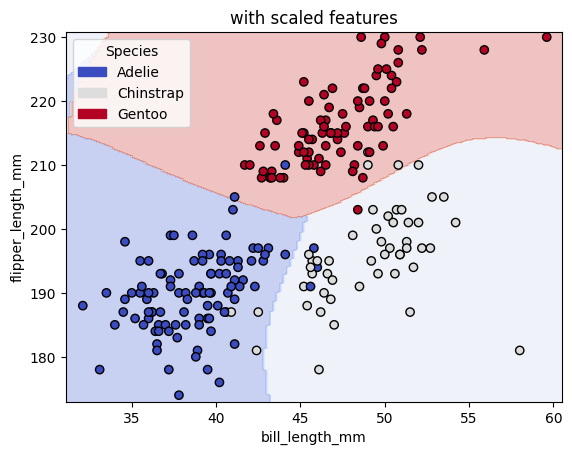

In [16]:
model.fit(X_train, y_train)
print(f'Training set Accuracy: {model.score(X_train, y_train)}')
print(f'Testing set Accuracy: {model.score(X_test, y_test)}')
plot_svm2d(X_train, selected_features[0], selected_features[1], y_train, model, "with scaled features")

Our model now generalizes much better with a simple scaling trick!

## Experiment with mislabeling

As supervised machine learning models require target (labeled) data to learn the mapping from input data, data acquisition and annotation play very important roles for such algorithms to have accurate true labels, classes for classification task and values for regression task, to learn about realistic natures of data.

This introductory experiment shows how mislabeling can affect the learning algorithm, by simply randomly changing the penguin species in our dataset to either of the other 2 classes. We construct the experiment with ipywidget allowing to specify the amount of mislabeled data interactively.

Let's execute this experiment in the code blocks below.

In [17]:
# repeated here again, features selection
selected_features = ['bill_length_mm', 'flipper_length_mm']

In [18]:
from sklearn.utils import resample

from ipywidgets import interact
import ipywidgets as widgets

trainsize_widget = widgets.FloatSlider(
    value=0.7,
    min=0.5,
    max=0.8,
    step=0.05,
    description='Training size:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.0%',
)
mislabel_widget = widgets.FloatSlider(
    value=0.2,
    min=0.0,
    max=0.5,
    step=0.005,
    description='Mislabeled:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1%',
)
status_widget = widgets.Label(value='')

def svm_interact(trainsize, mislabel):
    status_widget.value = 'Calculating...'
    
    X, y = penguins[selected_features].copy(), penguins[target[0]].copy()
    
    if mislabel > 0.0:
        y_mis = resample(y, n_samples=int(y.shape[0]*mislabel), replace=False, random_state=21)
        for i in y_mis.index:
            label=['Chinstrap','Gentoo','Adelie']
            label.remove(y_mis[i])
            newlabel = resample(label, n_samples=1)[0]
            y[i] = newlabel

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=trainsize, random_state=21, stratify=y)

    num_scaler = StandardScaler()

    model = Pipeline(steps=[
        ('scaler', num_scaler),
        ('classifier', SVC())
    ])

    model.fit(X_train, y_train)
    
    plot_svm2d(X_train, selected_features[0], selected_features[1], y_train, model, "Mislabeling experiment")
    print(f'Training set Accuracy: {model.score(X_train, y_train)}')
    print(f'Testing set Accuracy: {model.score(X_test, y_test)}')
    
    status_widget.value = 'Calculation completed!'

interact(svm_interact, trainsize=trainsize_widget, mislabel=mislabel_widget)
display(status_widget)

interactive(children=(FloatSlider(value=0.7, continuous_update=False, description='Training size:', max=0.8, m…

Label(value='Calculation completed!')

The "Training size" slider controls the number of training data split and the rest will be in the testing split. The "Mislabeled" slider specifies the amount of incorrectly labeled data in the whole dataset because regardless of training or testing splits they are from the same data acquisition and annotation processes.

It can be observe from the plot that, as the number of mislabeled data increases, the overall data are cluttered meaning the true shape of data is not presented. The decision boundaries are also affected, which will not be a good enough model to classify unseen data.